# Time Series Analysis for the unemployment rate in Medellín city and its Metropolitan Area
In the objective: characterize the macroeconomic variable to estimate. We want to propose a timeseries model that serves helpes us to construct a machine learning model with the unemployment rate and the count of the automobiles in the city. 

### Necessary packages

In [1]:
import pandas as pd
from arch.unitroot import DFGLS,ADF
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
import numpy as np
import itertools
import datetime
from scipy.stats import norm
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import sys
import warnings
from tqdm import tqdm
from arch.unitroot import PhillipsPerron
warnings.simplefilter('ignore')
%matplotlib inline

### Data reading and formatting
The data for the unemployment rate was previously processed and can be found in 'Datos-procesados.csv'. The original data came from the National Administrative Department of Statistics, DANE, [Gran encuesta integrada de hogares, GEIH]('http://www.dane.gov.co/index.php/178-english/sociales/cultura/2921-gran-encuesta-integrada-de-hogares'). The first series are quarterly, from 1984-2000. And the most recent series are a moving quarter series, from 2000-2018, with monthly value.

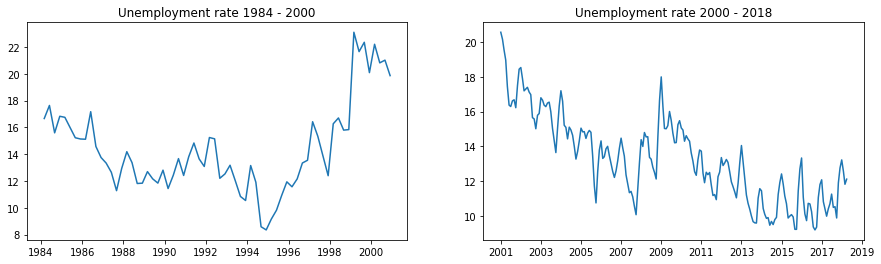

In [2]:
camila = open('Datos-procesados.csv', 'r').read()
camila = list(map(lambda x: x.split(','), camila.split('\n')))
for row in camila:
    if row[0]:
        año = row[0]
    else:
        row[0] = año
    
# this series referes to historical series, containing quarterly information
# given by the previous survey
historico = list(filter(lambda x: not '-' in x[1], camila[1:-1]))

# this series contains the quearter mobile data given bu the GEIH survey
reciente = list(filter(lambda x: '-' in x[1], camila[1:-1]))

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
time = []
value = []
if historico:
    for i in historico:
        año, mes, v = i
        if not 'N' in v:
            mes = 1 + meses.index(mes[:3].lower())
            date = datetime.datetime(int(año), mes, 1)
            time.append(date)
            value.append(float(v))
        
    dfH = pd.Series(value, time)

time1 = []
value1 = []
for j in reciente:
    año, mes, v = j
    mes = 1 + meses.index(mes[:3].lower())
    date = datetime.datetime(int(año), mes, 1)
    time1.append(date)
    value1.append(float(v))
    
dfR = pd.Series(value1, time1)
if historico:
# Graph data
    fig, axes = plt.subplots(1, 2, figsize=(15,4))

# Levels
    axes[0].plot(dfH, '-')
    axes[0].set(title='Unemployment rate 1984 - 2000')

    axes[1].plot(dfR, '-')
    axes[1].set(title='Unemployment rate 2000 - 2018');
else:
    plt.plot(dfR, '-')
    plt.show()

# Time series analysis for the moving-quarter data
From now on, we are working with the data for the unemployment rate for the years 2000-2018. Thsi due to the fact thay they are measured in a different scale, and the recent infomration is more useful for the purposes of this research.

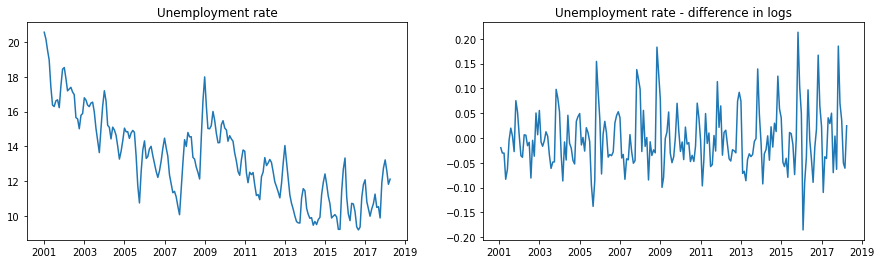

In [3]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

# Levels
axes[0].plot(dfR, '-')
axes[0].set(title='Unemployment rate')

# Variance
dfR = np.log(dfR)

# Log difference
axes[1].plot(dfR.diff(), '-')
axes[1].set(title='Unemployment rate - difference in logs');
dfR.diff().to_csv('UnemploymentDiff.csv')

### Finding possible seasonal components
Observing the behavior of the colombian economy, one could expect to find seasonal patterns in the data.

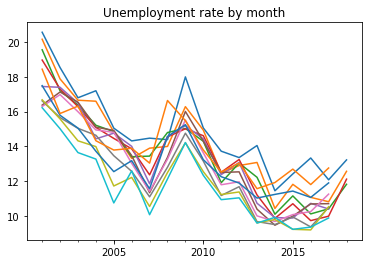

In [4]:
import matplotlib.cm as cm

series = []
for i in range(12):
    ma = i + 1
    time = []
    value = []
    for j in reciente:
        año, mes, v = j
        mes = 1 + meses.index(mes[:3].lower())
        if mes == ma: 
            date = datetime.datetime(int(año), mes, 1)
            time.append(date)
            value.append(float(v))
    series.append(pd.Series(value, time))
    
for i in range(len(series)):
    series[i].to_csv('serie-{}.csv'.format(i+1))
    series[i].plot()

plt.title("Unemployment rate by month")
plt.show()

### Series autocorrelations
The autocorrelation and partial autocorrelation graphics give us a first sight of the process, wether it has a moving average, autorregressive part or both

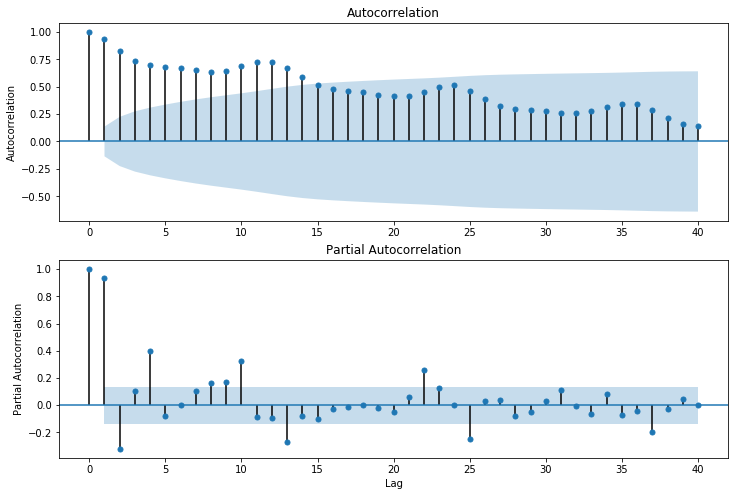

In [5]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
ax1.set_ylabel('Autocorrelation')
fig = sm.graphics.tsa.plot_acf(dfR.values.squeeze(), lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
ax2.set_ylabel('Partial Autocorrelation')
ax2.set_xlabel('Lag')
fig = sm.graphics.tsa.plot_pacf(dfR, lags = 40, ax = ax2)

AS one can notice, the series present autocorrelation patterns and Moving Average.

### Dickey Fuller test for unit roots
The null-hypothesis stands for the presence of a unit root, this meaning the series are non stationary. For a p-value greater than 0.05 can not reject the null hypothesis, thus, the series may be non stationary

In [6]:
# Test for the original series
print('Unemployment rate\n')
adf = ADF(dfR)
print(adf.summary().as_text())

# Test for the differentiated series
print('\n Differentiated Unemployment rate \n')
adf = ADF(dfR.diff()[1:])
print(adf.summary().as_text())

Unemployment rate

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.933
P-value                         0.317
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

 Differentiated Unemployment rate 

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.015
P-value                         0.033
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


The process is integrated of order 1. The null hypothesis is rejected for the differentiated series. One can also apply the Dickey Fuller GLS test to check the unit root

In [7]:
# Test for the original series
print('Unemployment rate\n')
dfgls = DFGLS(dfR)
dfgls.trend = 'c'
dfgls.lags = 20
print(dfgls.summary().as_text())

# Test for the differentiated series
print('\n Differentiated Unemployment rate \n')
dfgls = DFGLS(dfR.diff()[1:])
dfgls.trend = 'ct'
dfgls.lags = 20
print(dfgls.summary().as_text())

Unemployment rate

      Dickey-Fuller GLS Results      
Test Statistic                 -0.151
P-value                         0.639
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -2.67 (1%), -2.05 (5%), -1.74 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

 Differentiated Unemployment rate 

      Dickey-Fuller GLS Results      
Test Statistic                 -3.057
P-value                         0.029
Lags                               20
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.52 (1%), -2.95 (5%), -2.66 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### KPSS stationarity test
Now, we perform a different test for the series, to check wether or not they are stationary

In [8]:
from arch.unitroot import KPSS
kpss = KPSS(dfR)
print(kpss.summary().as_text())
kpss = KPSS(dfR.diff()[1:])
print(kpss.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  1.716
P-value                         0.000
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.169
P-value                         0.337
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


For the original series, the null hypothesis of stationarity is rejected, and for the differentiated series one can not reject the stationarity. So, we have evidence with three tests of the unit root of the series, so we would expect a model that fits these characteristics.

## Fitting a SARIMA model 
Due to the evidence shown of unit roots and possible seasonal components in the series, also the moving average and autorregressive component in the series shown in the correlation and partial correlation graphs, is time to fit a SARIMA model for the series. The parameters are going to be tested with the Akaike Information Criteria (AIC) for choosing the best model.

In [9]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(dfR,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity = True,
                                                enforce_invertibility = False)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

100%|██████████| 27/27 [19:06<00:00, 45.11s/it]

Best SARIMAX(2, 1, 2)x(2, 0, 1, 12)12 model - AIC:-777.1893014656839


In [11]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(dfR,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity = True,
                                                enforce_invertibility = False)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            continue
print("Best SARIMAX{}x{}6 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

100%|██████████| 27/27 [07:30<00:00, 17.13s/it]

Best SARIMAX(1, 1, 2)x(2, 0, 2, 6)6 model - AIC:-761.7393240976585


In [12]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(dfR,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity = True,
                                                enforce_invertibility = False)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            continue
print("Best SARIMAX{}x{}3 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

100%|██████████| 27/27 [03:52<00:00,  9.96s/it]

Best SARIMAX(1, 1, 0)x(1, 0, 2, 3)3 model - AIC:-727.1100006176832


In [13]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in tqdm(pdq):
    try:
        tmp_mdl = sm.tsa.statespace.SARIMAX(dfR,
                                            order = param,
                                            enforce_stationarity = True,
                                            enforce_invertibility = False)
        res = tmp_mdl.fit()
        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = param
            best_mdl = tmp_mdl
    except:
        continue
print("Best ARIMAX{} model - AIC:{}".format(best_pdq, best_aic))

100%|██████████| 27/27 [00:01<00:00, 11.11it/s]

Best ARIMAX(2, 1, 2) model - AIC:-665.2659338698272


### Results of the estimation
After hours of running (one can try again), the estimation results for different values of p,d,q and s are given by:
Best SARIMAX(2, 1, 2)x(2, 0, 1, 12)12 model - AIC:-778.5472719558979
Best SARIMAX(1, 1, 2)x(2, 0, 2, 6)6 model - AIC:-761.73932409765854
Best SARIMAX(1, 1, 0)x(1, 0, 2, 3)3 model - AIC:-727.1100006176832
Best ARIMAX(2, 1, 2) model - AIC:-665.2659338698272

So, we choose the model SARIMAX(2, 1, 2)x(2, 0, 1, 12)12

In [4]:
# Estimation of the model
model = sm.tsa.statespace.SARIMAX(dfR, 
                                    order = (2,1,2), 
                                    seasonal_order = (2,0,1,12),
                                    enforce_stationarity = True,
                                    enforce_invertibility = False)
model_fit = model.fit(disp=0)
output = model_fit.forecast()
yhat = output[0]
print(np.exp(output))

2018-05-01    11.957176
Freq: MS, dtype: float64


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  208
Model:             SARIMAX(2, 1, 2)x(2, 0, 1, 12)   Log Likelihood                 396.595
Date:                            Sun, 07 Apr 2019   AIC                           -777.189
Time:                                    15:30:48   BIC                           -750.528
Sample:                                01-01-2001   HQIC                          -766.408
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5308      0.095     -5.610      0.000      -0.716      -0.345
ar.L2         -0.3609      0.092   

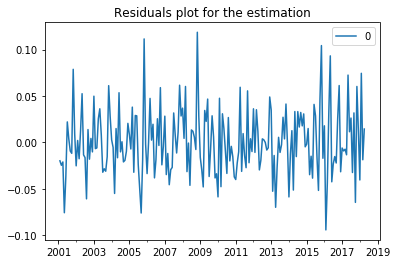

                0
count  207.000000
mean     0.000352
std      0.035378
min     -0.094147
25%     -0.022115
50%     -0.004693
75%      0.025636
max      0.118650


In [5]:
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals = residuals[1:]
residuals.to_csv('residuals.csv')
residuals.plot()
plt.title('Residuals plot for the estimation')
plt.show()
print(residuals.describe())

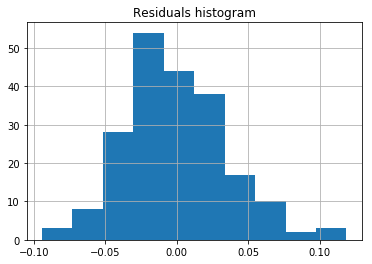

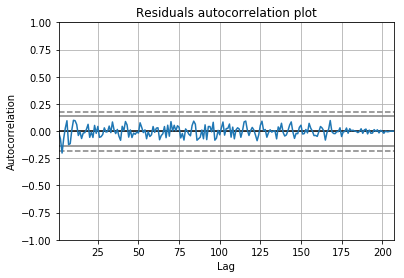

In [11]:
# Check if the residuals are white noise
residuals.hist()
plt.title('Residuals histogram')
plt.show()

from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(residuals)
plt.title('Residuals autocorrelation plot')
plt.show()

The correlogram does not show any obvious autocorrelation pattern. Above the 95% and 99% confidence level, one does not observe any spikes in the data. Also, the histogram shows that the density function of the residuals is similar to a normal distribution, with mean zero and variance 0.03.

### Model fit - Mean Squared Error
For this step, we calculate a simple metric in order to evaluate the fitness of our model. This is done by passing a sliding window across the data and comparing the predictions of the model against the real value.

In [6]:
camila = open('Datos-procesados1.csv', 'r').read()
camila = list(map(lambda x: x.split(','), camila.split('\n')))
for row in camila:
    if row[0]:
        año = row[0]
    else:
        row[0] = año
    
# this series contains the quearter mobile data given bu the GEIH survey
reciente = list(filter(lambda x: '-' in x[1], camila[1:-1]))

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
time = []
value = []

time1 = []
value1 = []
for j in reciente:
    año, mes, v = j
    mes = 1 + meses.index(mes[:3].lower())
    date = datetime.datetime(int(año), mes, 1)
    time1.append(date)
    value1.append(float(v))
    
dfT = pd.Series(value1, time1)
dfT = np.log(dfT)

In [22]:
series = dfT
X = series.values
size = int(len(X) * 0.25)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
error = list()
for t in tqdm(range(len(test))):
    model = sm.tsa.statespace.SARIMAX(history, 
                                    order = (2,1,2), 
                                    seasonal_order = (2,0,1,12),
                                    enforce_stationarity = False,
                                    enforce_invertibility = False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    try:
        obs = test[t]
        history.append(obs)
        error1 = mean_squared_error(test[0:t+1], predictions)
        error.append(np.sqrt(error1))
        error2 = mean_squared_error(test, predictions)
        print('Test MSE: %.3f' % error2)
    except:
        pass
	#print('predicted=%f, expected=%f' % (yhat, obs))


Test MSE: 0.002


In [20]:
preds = []
num = 6
for i in range(num):
    model = sm.tsa.statespace.SARIMAX(history, 
                                    order = (2,1,2), 
                                    seasonal_order = (2,0,1,12),
                                    enforce_stationarity = False,
                                    enforce_invertibility = False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(np.exp(yhat))
    history.append(yhat)

In [23]:
preds = np.exp(np.array(predictions)[-6:])
len(preds)

6

#### Root mean squared error
This is the same metric as before, now we want to see it in the same scale as our data.

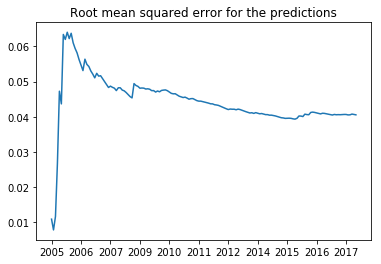

In [16]:
# plot
PASSOS = 15
TICKS = dfT[-len(predictions)::PASSOS].index

test = np.exp(test)

plt.xticks(np.arange(len(predictions), step=PASSOS), map(lambda x: x.year, TICKS))
plt.plot(error)
plt.title('Root mean squared error for the predictions')
plt.show()
error = pd.Series(error, index = dfT[-len(predictions):].index)
error.to_csv('elError.csv')

#### Results of the estimation
In the red line we can see the results for the model estimation, against the real values in the blue line.

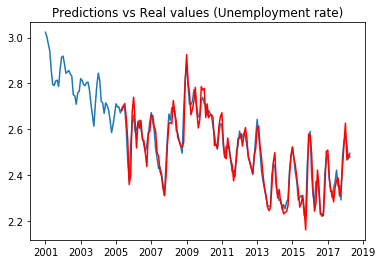

In [18]:
TICK = dfT[-len(predictions):].index
tst = pd.Series(data=predictions, index = TICK)
plt.plot(dfT)
plt.plot(tst, color = 'red')
plt.title('Predictions vs Real values (Unemployment rate)')
plt.show()
tst.to_csv('laRoja.csv')

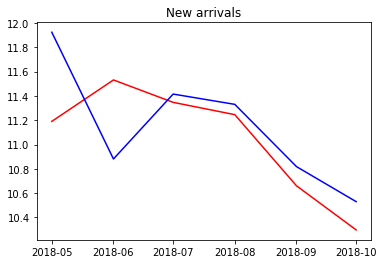

8.759522257836545
6


In [24]:
nuevos = []
for i in range(5,10):
    nuevos.append(dfT['2018-0'+str(i)+'-01'])
nuevos.append(dfT['2018-10-01'])
error = np.sqrt(mean_squared_error(nuevos, preds))

nuevos = dfT[-len(preds):]
nuevos = np.exp(nuevos)
TICK = dfT[-len(preds):].index
predd = pd.Series(data=preds, index = TICK)
plt.plot(nuevos, 'red')
plt.plot(predd, 'blue')
plt.title('New arrivals')
plt.show()
print(error)

print(len(predd))

In [25]:
error = np.sqrt(mean_squared_error(nuevos, preds))
error

0.4191150282866541

In [26]:
np.max(np.abs(nuevos-predd))

0.734290565313918

In [27]:
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return h

In [28]:
h = mean_confidence_interval(nuevos, confidence=0.95)

In [35]:
data = [
    go.Scatter(
        name='Valores reales',
        x=nuevos.index,
        y=nuevos.values,
        error_y=dict(
            type='data',
            array=[h for i in range(len(preds))],
            visible=True
        )
    )
    , trace1
]

layout = go.Layout(
    yaxis=dict(title='Tasa de desempleo'),
    xaxis=dict(title='Tiempo'),
    title='Ajuste del modelo',
    showlegend = True)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='percent-error-bar')